# Bayes Course Pre-Work

As a first step, import some of the libraries we will be using in the course. This will test that everything is installed correctly on your system. Running the cell below should not return errors.

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import pandas as pd
import pymc as pm
import sklearn as sk
import seaborn as sns
import pytensor.tensor as pt
import pytensor

print('All packages imported successfully!')

All packages imported successfully!


If everything was imported, you are ready to work through the exercises below.

## Data Import and Manipulation

Loading and processing data has become easier since the development of the `pandas` library, which provides data structures and functions for automating key data operations. 

For importing data from most common storage formats, several `read_*` functions are available.

In [2]:
[f for f in dir(pd) if f.startswith('read_')]

['read_clipboard',
 'read_csv',
 'read_excel',
 'read_feather',
 'read_fwf',
 'read_gbq',
 'read_hdf',
 'read_html',
 'read_json',
 'read_orc',
 'read_parquet',
 'read_pickle',
 'read_sas',
 'read_spss',
 'read_sql',
 'read_sql_query',
 'read_sql_table',
 'read_stata',
 'read_table',
 'read_xml']

The `../data/` subdirectory includes some clinical trial data in `cdystonia.csv`. Choose the appropriate function and use it to import this data to a variable called `cdystonia`. Print the first 15 lines of the resulting `DataFrame`.

In [56]:
cdystonia = pd.read_csv("../data/cdystonia.csv")
cdystonia.head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


In [43]:
cdystonia.nunique()

patient    109
obs          6
week         6
site         9
id          19
treat        3
age         45
sex          2
twstrs      62
dtype: int64

This dataset is from [Statistical Methods for the Analysis of Repeated Measurements](http://www.amazon.com/Statistical-Methods-Analysis-Repeated-Measurements/dp/0387953701) by Charles S. Davis, pp. 161-163 (Springer, 2002). These data are from a multicenter, randomized controlled trial of botulinum toxin type B (BotB) in patients with cervical dystonia from nine U.S. sites.

Patients were randomized to placebo (N=36), 5000 units of BotB (N=36), or 10,000 units of BotB (N=37). The response variable is the total score on Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment). TWSTRS was measured at baseline (week 0) and weeks 2, 4, 8, 12, 16 after treatment began, so this is a longitudinal study.

1. Since there are repeated measures of each patient, the `patient` column alone cannot be used as an index, because it is not unique. Use some of the columns in the DataFrame to create an index for the data that is unique.

In [57]:
cdystonia["index"] = cdystonia["patient"].astype(str) + "|" + cdystonia["obs"].astype(str)
cdystonia["week_nm"] = "week" + "_" + cdystonia["week"].astype(str)
cdystonia.head()

,patient,obs,week,site,id,treat,age,sex,twstrs,index,week_nm
0,1,1,0,1,1,5000U,65,F,32,1|1,week_0
1,1,2,2,1,1,5000U,65,F,30,1|2,week_2
2,1,3,4,1,1,5000U,65,F,24,1|3,week_4
3,1,4,8,1,1,5000U,65,F,37,1|4,week_8
4,1,5,12,1,1,5000U,65,F,39,1|5,week_12


2. The `cdystonia` dataset is stored in **long** format, meaning that each row contains a single observation. Use pandas functions and methods to change the data to **wide** format, where each row represents the data for a single patient. 

In [58]:

cdystonia_wide = cdystonia.pivot(
    index=["patient", "site", "id", "treat", "age"],
    columns="week_nm",
    values="twstrs"
    )
cdystonia_wide.columns.name = None
cdystonia_wide = cdystonia_wide.reset_index()
cdystonia_wide.head()

,patient,site,id,treat,age,week_0,week_12,week_16,week_2,week_4,week_8
0,1,1,1,5000U,65,32.0,39.0,36.0,30.0,24.0,37.0
1,2,1,2,10000U,70,60.0,65.0,67.0,26.0,27.0,41.0
2,3,1,3,5000U,64,44.0,35.0,35.0,20.0,23.0,26.0
3,4,1,4,Placebo,59,53.0,NaN,NaN,61.0,64.0,62.0
4,5,1,5,10000U,76,53.0,41.0,51.0,35.0,48.0,49.0


3. To get an idea about the efficacy of the treatment, use `pandas` to group the data by treatment group, and calculate the mean and standard deviation of the `twstrs` outcome variable for each group in week 4.

In [59]:
# Your answer here
# As a sanity check, this should be the answer:

#                mean       std
# treat
# 10000U         34.805556  12.188565
# 5000U          37.114286  15.311993
# Placebo        39.342857  11.827045

cdystonia_wide.groupby(["treat"], as_index=False).agg(
    mean=("week_4", "mean"),
    std=("week_4", "std"),
)

,treat,mean,std
0,10000U,34.805556,12.188565
1,5000U,37.114286,15.311993
2,Placebo,39.342857,11.827045


4. Since this is a longitudinal study, graphics are helpful for understanding the dynamics of the experiment. Using the plotting package of your choice (there are many for Python!) create a set of plots showing how the response variable changes over time for each experimental group. 

<Axes: xlabel='week', ylabel='twstrs'>

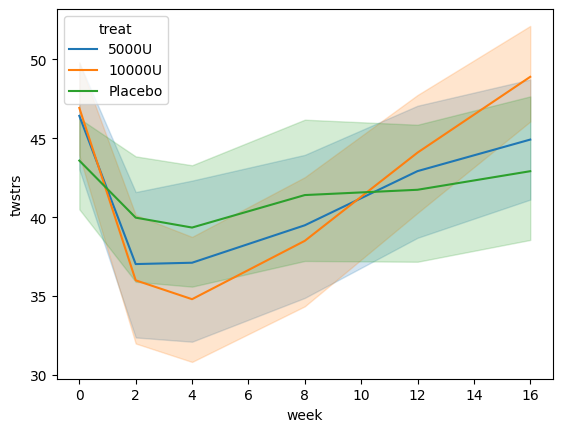

In [60]:
sns.lineplot(x='week', y='twstrs', hue='treat', data=cdystonia)

## Linear Algebra


Operations become much faster when we can express them as vectorized linear algebra commands. One example is generating multivariate normal distributions.

Suppose we wish to generate samples with mean $\mu$ and covariance $\Sigma$, where $\mu$ is $n \times 1$ and $\Sigma$ is $n \times n$. One way to do this is to calculate a [*Cholesky decomposition*](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, so that
$$
\Sigma = LL^T.
$$

Then if $x$ is $n$ independent draws from a standard normal distribution, 
$$
\nu = Lx + \mu \sim \mathcal{N}(\mu, \Sigma)
$$

### Exercises
Let $\mu = (3, 2)$, and
$$
\Sigma = \left(\begin{array}{cc}
1 & 0.9 \\
0.9 & 1
\end{array}\right)
$$

1. Use `np.linalg.cholesky` to compute $L$, the Cholesky decomposition of $\Sigma$
2. In newer Python (3.6+), `@` is matrix multiplication. Confirm that $\Sigma = LL^T$.
3. Draw 2 independent draws from a standard normal using `x = np.random.randn(2)`, and compute $\nu$ using `L @ x + mu`
4. The above exercise generates 1 draw from a multivariate normal. Use `x = np.random.randn(2, 1_000)` and the same formula as above to generate 1,000 draws.

In [61]:
mu = np.array([[3], [2]])
sigma = np.array([[1, 0.9], [0.9, 1]])

In [67]:
# Use `np.linalg.cholesky` to compute $L$, the Cholesky decomposition of `sigma`
L = np.linalg.cholesky(sigma)
L

array([[1.        , 0.        ],
       [0.9       , 0.43588989]])

In [68]:
# In newer Python (3.7+), `@` is matrix multiplication. Confirm that `sigma = L @ L.T`
L @ L.T

array([[1. , 0.9],
       [0.9, 1. ]])

In [69]:
# Draw 2 independent draws from a standard normal using `x = np.random.randn(2)`, and compute `nu` using `L @ x + mu`
x = np.random.randn(2)
nu = L @ x + mu
nu

array([[2.15390258, 2.11538005],
       [1.15390258, 1.11538005]])

In [70]:
# The above exercise generates 1 draw from a multivariate normal. Use `x = np.random.randn(2, 1_000)` and the same formula as above to generate 1,000 draws
x = np.random.randn(2, 1_000)
nu = L @ x + mu
nu

array([[3.15511184, 1.97905428, 4.0570217 , ..., 3.11981818, 2.02782046,
        1.74115809],
       [1.7502478 , 1.73842785, 3.17380438, ..., 2.06714615, 0.59660565,
        1.43684864]])

## Probability Distributions and Simulation

Bayesian inference relies on the use of probability distributions for constructing models. Though several statistical and machine learning packages implement their own set of probability distributions, the NumPy and SciPy libraries include general-purpose functions and classes for performing probability operations. 

NumPy has an efficient set of random number generators for different distributions, while SciPy implements a large set of complete probability distributions that allow them to be used in most applications.

In [71]:
from scipy.stats import distributions as dists

In [72]:
dir(dists)[-20:]

['tukeylambda_gen',
 'uniform',
 'uniform_gen',
 'vonmises',
 'vonmises_gen',
 'vonmises_line',
 'wald',
 'wald_gen',
 'weibull_max',
 'weibull_max_gen',
 'weibull_min',
 'weibull_min_gen',
 'wrapcauchy',
 'wrapcauchy_gen',
 'yulesimon',
 'yulesimon_gen',
 'zipf',
 'zipf_gen',
 'zipfian',
 'zipfian_gen']

Let's look at a gamma distribution as an example:

In [73]:
gamma_dist = dists.gamma

Inspecting the attributes of `gamma_dist`, we can see several important methods, including `pdf` (probability distribution function), `cdf` (cumulative distribution function), `rvs` (random number generator), and more.

In [74]:
[f for f in dir(gamma_dist) if not f.startswith('_')]

['a',
 'b',
 'badvalue',
 'cdf',
 'entropy',
 'expect',
 'extradoc',
 'fit',
 'fit_loc_scale',
 'freeze',
 'generic_moment',
 'interval',
 'isf',
 'logcdf',
 'logpdf',
 'logsf',
 'mean',
 'median',
 'moment',
 'moment_type',
 'name',
 'nnlf',
 'numargs',
 'pdf',
 'ppf',
 'random_state',
 'rvs',
 'sf',
 'shapes',
 'stats',
 'std',
 'support',
 'var',
 'vecentropy',
 'xtol']

### Exercise: Simulating linear regression

1. Generate a (1000, 10) `features` array using a uniform distribution.
2. Generate a (10, 1) `weights` array, using a normal distribution with standard deviation 2 and mean 0. Note this is typically unobserved.
3. Generate a (1000, 1) `noise` array, using a normal distribution with standard deviation 1 and mean 0. Note that this is typically unobserved.
4. Compute (1000, 1) `target` array, as `features @ weights + noise`
5. Recover an estimate for the weights using `np.linalg.pinv(features) @ target` (`pinv` is the [Moore-Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse))
6. Our statistical model is 
$$
\text{weights} \sim \mathcal{N}(0, 2) \\
\text{target} | \text{features}, \text{weights} \sim \mathcal{N}(\text{features} \cdot \text{weights}, 1)
$$
What is the log probability that all the weights are 0, and all the targets are 1, given your generated `features`?
7. What is the log probability of your generated `weights` and generated `targets`, given your generated `features`?

In [84]:
# Generate a (1000, 10) `features` array using a uniform distribution.
features = np.random.rand(1000, 10)

assert features.shape == (1000, 10)

In [85]:
# Generate a (10, 1) `weights` array, using a normal distribution with standard deviation 2 and mean 0
weights = np.random.normal(0, 2, size=(10, 1))
assert weights.shape == (10, 1)

In [86]:
# Generate a (1000, 1) `noise` array, using a normal distribution with standard deviation 1 and mean 0
noise = np.random.normal(0, 1, size=(1000, 1))
assert noise.shape == (1000, 1)

In [87]:
# Compute (1000, 1) `target` array, as `features @ weights + noise`
target = features @ weights + noise
assert target.shape == (1000, 1)

In [92]:
# Recover an estimate for the weights using `np.linalg.pinv(features) @ target`
estimate = np.linalg.pinv(features) @ target
estimate

array([[ 0.75034637],
       [ 0.03530141],
       [-2.55800453],
       [-1.22596423],
       [-2.4045677 ],
       [-3.37993267],
       [-0.32307457],
       [-0.61137094],
       [-0.6192338 ],
       [-2.17157294]])

In [90]:
# Compute the log probability that all the weights are 0, and all the targets are 1, given your generated `features`
sp.stats.norm.logpdf(weights, loc=0, scale=2).sum()

-20.081390627396814

In [91]:
# Compute the log probability of your generated `weights` and `targets`, given your generated `features`
sp.stats.norm.logpdf(target, loc=features@weights, scale=1).sum()

-1415.004453622128

Your answer to 5 above should match the answer `scikit-learn` provides:

In [93]:
# from sklearn.linear_model import LinearRegression

# LinearRegression(fit_intercept=False).fit(features, target).coef_.T
from sklearn.linear_model import LinearRegression
LinearRegression(fit_intercept=False).fit(features, target).coef_.T

array([[ 0.75034637],
       [ 0.03530141],
       [-2.55800453],
       [-1.22596423],
       [-2.4045677 ],
       [-3.37993267],
       [-0.32307457],
       [-0.61137094],
       [-0.6192338 ],
       [-2.17157294]])

## Optimization

Another way of running linear regression is via optimization. Suppose we want to minimize the sum of squares using scipy. We can do this using `scipy.optimize`.

In [94]:
from scipy.optimize import fmin_bfgs

features = np.random.uniform(size=(1000, 10))
weights = np.random.normal(0, 2, size=(10, 1))
noise = np.random.normal(0, 1, size=(1000, 1))
target = (features @ weights + noise).flatten()


### Exercise

Find the weights with the least mean squared error using `fmin_bfgs`. It expects a function to minimize and an initial point.

1. The function to minimize should accept an argument `x`, and return `((features @ x - target) ** 2).mean()`
2. You can initialize with a vector of 10 zeros.

In [95]:
# Write the function to minimize, and an initial point

def loss_function(x):
    return ((features @ x - target)**2).mean()

initial_point = np.zeros(10)

assert initial_point.shape == (10,)

In [96]:
min_x = fmin_bfgs(loss_function, initial_point)
min_x

Optimization terminated successfully.
         Current function value: 1.052775
         Iterations: 14
         Function evaluations: 165
         Gradient evaluations: 15


array([ 1.11248872, -1.03863811,  0.4044424 , -0.01833622,  1.37898841,
        2.06774327,  1.92402396,  0.58136021,  1.40760569,  1.80045036])

This answer should match our solution using linear algebra, or using scikit-learn:

In [97]:
np.linalg.pinv(features) @ target

array([ 1.11249188, -1.03863667,  0.40443881, -0.01833624,  1.3789883 ,
        2.06773494,  1.92403496,  0.58135791,  1.40760549,  1.80044893])

In [98]:
from sklearn.linear_model import LinearRegression

LinearRegression(fit_intercept=False).fit(features, target).coef_.T

array([ 1.11249188, -1.03863667,  0.40443881, -0.01833624,  1.3789883 ,
        2.06773494,  1.92403496,  0.58135791,  1.40760549,  1.80044893])